In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [5]:
import pandas as pd
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')
#remouve nan values
anime = anime.dropna()
rating = rating.dropna()


rating['user_id'] = rating['user_id'].astype(str)
rating['anime_id'] = rating['anime_id'].astype(str)
#changing the type of anime id to string 
anime["anime_id"] = anime["anime_id"].astype(str)

unique_user_ids = list(rating.user_id.unique())
unique_anime_ids = list(anime.anime_id.unique())
unique_genres = list(anime.genre.unique())
unique_types = list(anime.type.unique())
unique_ratings = list(rating.rating.unique())

##

In [6]:
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [7]:
unique_user_ids = np.unique(unique_user_ids)
unique_anime_ids = np.unique(unique_anime_ids)
unique_genres = np.unique(unique_genres)
unique_types = np.unique(unique_types)


In [13]:
#preaparing the data for the model
columns = ['anime_id','genre','type']
data = rating.merge(anime[columns], on='anime_id')
#dropping the columns that are not needed


In [15]:

ratings = tf.data.Dataset.from_tensor_slices(dict(rating))
data = tf.data.Dataset.from_tensor_slices(dict(data))

In [16]:
tf.random.set_seed(42)
shuffled = data.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [10]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.anime_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_anime_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_anime_ids) + 1, embedding_dimension)
    ])
    self.genre_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_genres, mask_token=None),
      tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension)
    ])
    self.type_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_types, mask_token=None),
      tf.keras.layers.Embedding(len(unique_types) + 1, embedding_dimension)
    ])

    
    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    user_id, anime_id, genre, type = inputs
    
    """user_id=tf.convert_to_tensor(user_id)
    anime_id=tf.convert_to_tensor(anime_id)"""
    
    user_embedding = self.user_embeddings(user_id)
    anime_embedding = self.anime_embeddings(anime_id)
    genre_embedding = self.genre_embeddings(genre)
    type_embedding = self.type_embeddings(type)

    return self.ratings(tf.concat([user_embedding, anime_embedding,genre_embedding,type_embedding], axis=1))

In [11]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [12]:
class AnimeModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["anime_id"], features["genre"], features["type"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    """labels = features.pop("rating")

    rating_predictions = self(features)
    """
    features = features.copy()  # Make a shallow copy of features
    labels = features.pop("rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [71]:
model = AnimeModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


In [72]:
cached_train = train.shuffle(10_000).batch(8192).cache()
cached_test = test.batch(4096).cache()


In [73]:
two_layer_history = model.fit(cached_train, epochs=500,validation_data=cached_test)

Epoch 1/500


/Users/yassine/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'anime_model_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 11617.6523 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 76.3189 - total_loss: 11617.6523 - val_loss: 42.0493 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 6.5625 - val_total_loss: 42.0493
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22.0311 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 5.7103 - total_loss: 22.0311 - val_loss: 16.8311 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 3.9902 - val_total_loss: 16.8311
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.9932 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.6039 - total_loss: 12.9932 - val_loss: 13.5057 - val_regularization_loss: 0.0000e+00 - val_root_mean_squared_error: 3.6222 - val_total_loss: 13.5057
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.8776 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.5720 - total_loss: 12.8776 - val_

In [74]:
model.evaluate(cached_test, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0214 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 2.8127 - total_loss: 8.0214 


{'loss': 8.326522827148438,
 'regularization_loss': 0.0,
 'root_mean_squared_error': 2.8198535442352295,
 'total_loss': 8.326522827148438}

In [75]:

accuracy = two_layer_history.history
loss = accuracy['loss']
val_loss = accuracy['val_loss']


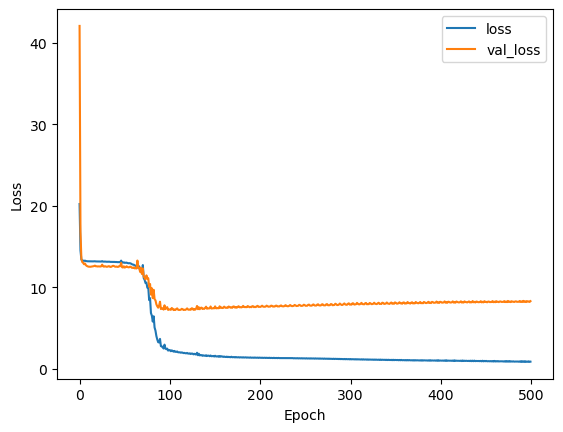

In [76]:
#plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
